<a href="https://colab.research.google.com/github/budennovsk/Pandas/blob/master/tfp_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype int64 requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will

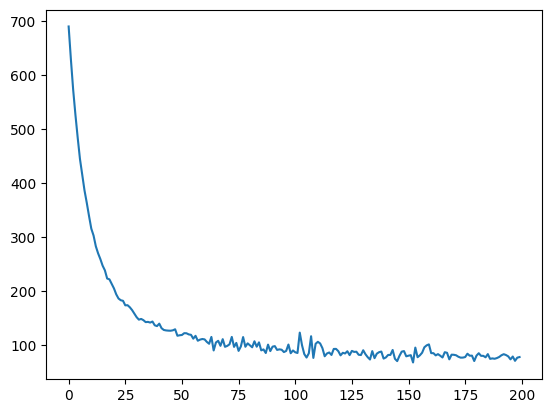

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype int64 requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will

In [16]:
import jax
import jax.numpy as jnp
from jax import random
from tensorflow_probability.substrates import jax as tfp
import optax
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

# Импорт компонентов, необходимых для анализа временных рядов
sts = tfp.sts
distributions = tfp.distributions
mcmc = tfp.mcmc

# Предположим, что у нас есть временной ряд наблюдаемых данных, который хранится в переменной obs_data
# Здесь мы инициализируем его как пример
x = jnp.array([10.0, 11.0, 9.0, 13.0, 14.0, 8.0, 12.0, 15.0, 7.0])
y = jnp.array([1, 1.0, 22.0, 22.0, 32.0, 2.0, 2.0, 154.0, 73.0])

# Определение модели временных рядов
seasonal_effect = sts.Seasonal(
    num_seasons=4,  # Это число должно соответствовать вашим данным; например, 4 для квартальных данных
    observed_time_series=x
)

# Комбинирование компонентов в одну модель
model = sts.Sum(
    [seasonal_effect],
    observed_time_series=x
)
# Build the variational surrogate posteriors `qs`.
init_fn, build_surrogate_fn = (
    tfp.sts.build_factored_surrogate_posterior_stateless(model=model))
# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 200
num_variational_steps = int(num_variational_steps)

seed = jax.random.PRNGKey(42)
init_seed, fit_seed, sample_seed = jax.random.split(seed, 3)
initial_parameters = init_fn(init_seed)
jd = model.joint_distribution(y)


# Build and optimize the variational loss function.
optimized_parameters, elbo_loss_curve = tfp.vi.fit_surrogate_posterior_stateless(
  target_log_prob_fn=jd.log_prob,
  initial_parameters=initial_parameters,
  build_surrogate_posterior_fn=build_surrogate_fn,
  optimizer=optax.adam(0.1),
  num_steps=num_variational_steps,
  seed=fit_seed)
plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
variational_posteriors = build_surrogate_fn(optimized_parameters)
q_samples_co2_ = variational_posteriors.sample(50, seed=sample_seed)


co2_forecast_dist = tfp.sts.forecast(
    model,
    observed_time_series=x,
    parameter_samples=q_samples_co2_,
    num_steps_forecast=4)

num_samples=10

co2_forecast_mean, co2_forecast_scale, co2_forecast_samples = (
    co2_forecast_dist.mean()[..., 0],
    co2_forecast_dist.stddev()[..., 0],
    co2_forecast_dist.sample(num_samples, seed=sample_seed)[..., 0])

In [17]:
co2_forecast_mean

Array([ 9.015063, 11.5313  , 14.501175,  8.952463], dtype=float32)